In [1]:
%run nb_header.py

Stata 17.0 (MP)


# Plotting CDC and CTP data on COVID-19

<div class="alert alert-block alert-info">
<b>Note:</b> Depends on files tmp/cdc_cleaned.dta generated by aggregate_counts.ipynb
and tmp/state_effects.csv generated by individual-level.ipynb.
</div>

## CDC data

Read data and generate CFR by month and ethnic group. We also drop data prior to March 2020, since Februrary 2020 includes no deaths.

In [2]:
%%stata -qui -doutd cdc_ethgrp
use res_state age_group ethgrp month deceased death_miss using tmp/cdc_cleaned ///
    if !death_miss & inlist(ethgrp,1,2,3), clear
gen grp = "White" if ethgrp==1
replace grp = "Black/AA" if ethgrp==2
replace grp = "LatinX" if ethgrp==3
frame copy default by_ethgrp
cwf by_ethgrp
collapse (mean) deceased, by(month grp)
noi li if !deceased
keep if month > tm(2020m2)
gen time = string(year(dofm(month))) + "-" + string(month(dofm(month)))

Plot CFR by month and ethnic group.

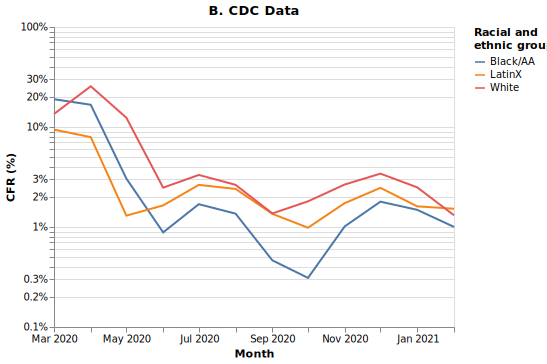

In [3]:
import pandas as pd
import altair as alt
alt.renderers.enable('svg')

cdc_ethgrp['time'] = pd.to_datetime(cdc_ethgrp.time)
fig1b = alt.Chart(cdc_ethgrp).mark_line().encode(
    alt.X('yearmonth(time):T',
          axis=alt.Axis(title='Month', grid=False, labelFlush=False)),
    alt.Y('deceased:Q',
          axis=alt.Axis(title='CFR (%)', format='%'),
          scale=alt.Scale(type='log')),
    color=alt.Color('grp:N',
                    legend=alt.Legend(title=['Racial and', 'ethnic group']))
).properties(
    title='B. CDC Data'
)

fig1b

Now compute CFR by state, ethnic group and age group.

In [4]:
%%stata -qui -doutd cdc_ethgrp_age
cwf default
keep if month > tm(2020m2) & inlist(age_group,"18 to 49 years","50 to 64 years","65+ years")
collapse (mean) deceased (count) n=deceased, by(res_state grp age_group)

Plot state-specific CFRs, separately by ethnic group and age group.

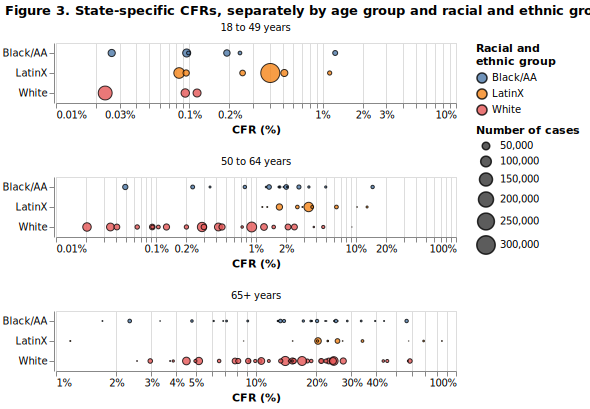

In [5]:
fig3 = alt.Chart(cdc_ethgrp_age).transform_filter(
    alt.datum.deceased > 0  
).mark_circle(
    opacity=0.8,
    stroke='black',
    strokeWidth=1
).encode(
    alt.X('deceased:Q', axis=alt.Axis(title='CFR (%)', format='%'),
          scale=alt.Scale(type='log')),
    alt.Y('grp:N', title=None),
    alt.Color('grp:N', legend=alt.Legend(title=['Racial and', 'ethnic group'])),
    alt.Size('n:Q',
        legend=alt.Legend(title='Number of cases'))
).facet(
    row=alt.Row('age_group:N', title=None, header=alt.Header(labelOrient='top'))
).resolve_scale(
    x='independent'
).properties(
    title='Figure 3. State-specific CFRs, separately by age group and racial and ethnic group (CDC data)'
).configure_title(
    anchor='start'
)

import altair_saver
altair_saver.save(fig3, 'tmp/fig3.pdf')
fig3

Let's see which states are included:

In [6]:
%stata table (res_state) (age_group["18 to 49 years" "50 to 64 years" "65+ years"] grp) if deceased, stat(count deceased) nototals


----------------------------------------------------------------------------------------------
          |                                      age_group                                    
          |        18 to 49 years              50 to 64 years                65+ years        
          |             grp                         grp                         grp           
          |  Black/AA   White   LatinX   Black/AA   White   LatinX   Black/AA   White   LatinX
----------+-----------------------------------------------------------------------------------
res_state |                                                                                   
  AL      |                                     1                           1       1         
  AR      |                                     1       1                   1       1         
  AZ      |                 1        1          1       1        1          1       1        1
  CA      |         1       1        1          1

Now we plot the state-specific random effects from our model. We'll grab the information for the background layer from https://hub.arcgis.com.

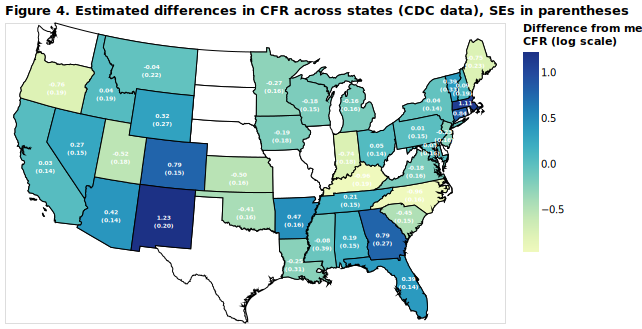

In [7]:
import requests
import geopandas as gpd
import numpy as np
import json

states_json = requests.get('https://opendata.arcgis.com/datasets/99fd67933e754a1181cc755146be21ca_0.geojson').json()
gdf = gpd.GeoDataFrame.from_features(states_json)

centroids = pd.DataFrame({'STATE_ABBR':gdf['STATE_ABBR'],
                          'latitude':gdf.centroid.x,
                          'longitude':gdf.centroid.y})
gdf['centroid_lon'] = gdf['geometry'].centroid.x
gdf['centroid_lat'] = gdf['geometry'].centroid.y
gdf['centroid_lon'] = gdf.centroid_lon.where(gdf.STATE_ABBR!='MI', gdf.centroid_lon + 0.3)
gdf['centroid_lon'] = gdf.centroid_lon.where(gdf.STATE_ABBR!='FL', gdf.centroid_lon + 1)
gdf['centroid_lon'] = gdf.centroid_lon.where(gdf.STATE_ABBR!='LA', gdf.centroid_lon - 0.5)
gdf['centroid_lat'] = gdf.centroid_lat.where(gdf.STATE_ABBR!='TN', gdf.centroid_lat + 0.4)
gdf['centroid_lat'] = gdf.centroid_lat.where(gdf.STATE_ABBR!='KY', gdf.centroid_lat + 0.4)
gdf['centroid_lon'] = gdf.centroid_lon.where(gdf.STATE_ABBR!='KY', gdf.centroid_lon + 0.5)
gdf['centroid_lat'] = gdf.centroid_lat.where(gdf.STATE_ABBR!='SC', gdf.centroid_lat + 0.4)
gdf['centroid_lat'] = gdf.centroid_lat.where(gdf.STATE_ABBR!='NC', gdf.centroid_lat + 0.4)
gdf['centroid_lat'] = gdf.centroid_lat.where(gdf.STATE_ABBR!='VA', gdf.centroid_lat + 0.4)
gdf['centroid_lat'] = gdf.centroid_lat.where(gdf.STATE_ABBR!='PA', gdf.centroid_lat + 0.3)
gdf['centroid_lat'] = gdf.centroid_lat.where(gdf.STATE_ABBR!='NY', gdf.centroid_lat + 0.3)
gdf['centroid_lat'] = gdf.centroid_lat.where(gdf.STATE_ABBR!='MD', gdf.centroid_lat + 0.5)
gdf['centroid_lon'] = gdf.centroid_lon.where(gdf.STATE_ABBR!='NJ', gdf.centroid_lon - 0.3)
gdf['centroid_lat'] = gdf.centroid_lat.where(gdf.STATE_ABBR!='NJ', gdf.centroid_lat + 0.2)
gdf['centroid_lat'] = gdf.centroid_lat.where(gdf.STATE_ABBR!='ME', gdf.centroid_lat + 0.5)
gdf['centroid_lon'] = gdf.centroid_lon.where(gdf.STATE_ABBR!='VT', gdf.centroid_lon - 0.3)
gdf['centroid_lat'] = gdf.centroid_lat.where(gdf.STATE_ABBR!='VT', gdf.centroid_lat + 0.4)
gdf['centroid_lat'] = gdf.centroid_lat.where(gdf.STATE_ABBR!='NH', gdf.centroid_lat + 0.2)
gdf['centroid_lat'] = gdf.centroid_lat.where(gdf.STATE_ABBR!='MA', gdf.centroid_lat + 0.1)

se = pd.read_csv('tmp/state_effects.csv')
gdf = gdf.merge(se, left_on='STATE_ABBR', right_on='res_state', how='outer')
gdf = gdf.loc[~gdf.STATE_ABBR.isin(['AK','HI','VI','MP','GU','AS','PR'])]

gdf['label'] = list(zip(gdf['re1'].map('{:,.2f}'.format), '(' + gdf['se1'].map('{:,.2f}'.format) + ')'))
gdf['label'] = gdf.label.where(~gdf.re1.isna(), '')
gdf['label2'] = gdf.label.str[0]
gdf['label'] = gdf.label.where(~gdf.STATE_ABBR.isin(['MA','CT']), gdf.label2)

map_json = json.loads(gdf.to_json())
map_data = alt.Data(values=map_json['features'])

background = alt.Chart(map_data).mark_geoshape(
    stroke='black',
    strokeWidth=1,
    fill='white',
).properties(
    title='Figure 4. Estimated differences in CFR across states (CDC data), SEs in parentheses',
    width=500,
    height=300
).project('albersUsa')

foreground = alt.Chart(map_data).mark_geoshape(
    stroke='black',
    strokeWidth=1
).encode(
    color=alt.Color('properties.re1:Q', legend=alt.Legend(title=['Difference from mean','CFR (log scale)']))
).properties(
    width=500,
    height=300
).project('albersUsa')

labels = alt.Chart(map_data).mark_text(color='white', fontSize=6, fontWeight='bold').encode(
    longitude='properties.centroid_lon:Q',
    latitude='properties.centroid_lat:Q',
    text='properties.label:N'
)

fig4 = (background + foreground + labels).configure_title(anchor='start')
altair_saver.save(fig4, 'tmp/fig4.pdf')
fig4

## CTP data

Now we plot the CTP data by month and ethnic group.

In [8]:
df = pd.read_csv('data/ctp/CRDT Data - CRDT.csv')
df['Cases_Other'] = df[['Cases_Asian','Cases_AIAN','Cases_NHPI','Cases_Multiracial','Cases_Other']].sum(axis=1)
df['Deaths_Other'] = df[['Deaths_Asian','Deaths_AIAN','Deaths_NHPI','Deaths_Multiracial','Deaths_Other']].sum(axis=1)
df['Cases_Missing'] = df.Cases_Total - df[['Cases_White','Cases_Black','Cases_Latinx','Cases_Other']].sum(axis=1)
df['Deaths_Missing'] = df.Deaths_Total - df[['Deaths_White','Deaths_Black','Deaths_Latinx','Deaths_Other']].sum(axis=1)
df = df.loc[df.Date<=20210228,['Date','State','Cases_Total','Deaths_Total','Cases_White','Deaths_White','Cases_Black',
                               'Deaths_Black','Cases_Latinx','Deaths_Latinx','Cases_Other','Deaths_Other','Cases_Missing',
                               'Deaths_Missing']]

Keep the last observation for each month, translate to monthly counts from cumulative counts, and reshape to long form. As with the aggregate analyses, since NY has no case counts by race/ethnicity we drop it.

In [9]:
%%stata -d df -force -qui
drop *_Total *_Other *_Missing
gen date = date(string(Date,"%8.0f"),"YMD")
gen month = mofd(date)
isid State month date, so
bys State month (date): keep if _n==_N
drop if State=="NY"

foreach var of varlist Cases_White Cases_Black Cases_Latinx Deaths_White Deaths_Black Deaths_Latinx {
    bys State (month): gen _`var' = `var' - `var'[_n-1] if (month - month[_n-1])==1
    bys State (month): replace _`var' = `var' if _n==1
}

reshape long _Deaths_ _Cases_, i(State month) j(grp) string
gen n0 = _Cases_ - _Deaths_
ren _Deaths_ n1
keep State month grp n0 n1
reshape long n, i(State month grp) j(deceased)
drop if mi(n)

Drop those state x month combinations with negative values.

In [10]:
%%stata -qui
noi table State month if n < 0
noi bys State month (n): drop if n[1] < 0


----------------------------------------------------------
        |                       month                     
        |  725   726   729   730   731   732   733   Total
--------+-------------------------------------------------
State   |                                                 
  CO    |          1                                     1
  HI    |                      1                 1       2
  IA    |                                        1       1
  MO    |                1                               1
  NE    |                                  1             1
  RI    |    3                                           3
  TX    |                            2     3     1       6
  VA    |    1                                           1
  Total |    4     1     1     1     2     4     3      16
----------------------------------------------------------
(54 observations deleted)



Compute CFR by month and ethnic group.

In [11]:
%%stata -qui -doutd ctp_ethgrp
replace grp = "Black/AA" if grp=="Black"
replace grp = "LatinX" if grp=="Latinx"
collapse (mean) deceased [fweight=n], by(month grp)
gen time = string(year(dofm(month))) + "-" + string(month(dofm(month)))

Plot CFR by month and ethnic group.

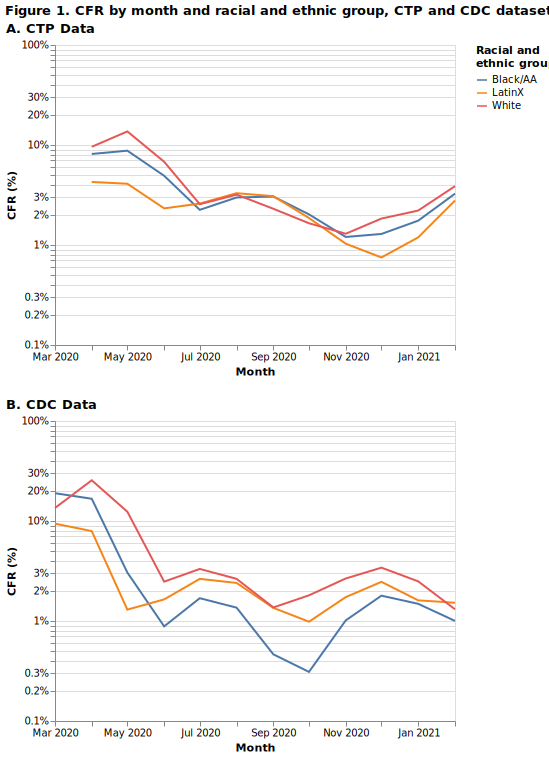

In [12]:
ctp_ethgrp['time'] = pd.to_datetime(ctp_ethgrp.time)
fig1a = alt.Chart(ctp_ethgrp).mark_line().encode(
    alt.X('yearmonth(time):T',
          axis=alt.Axis(title='Month', grid=False, labelFlush=False)),
    alt.Y('deceased:Q',
          axis=alt.Axis(title='CFR (%)', format='%'),
          scale=alt.Scale(type='log')),
    color=alt.Color('grp:N',
                    legend=alt.Legend(title=['Racial and', 'ethnic group']))
).properties(
    title='A. CTP Data'
)

title = 'Figure 1. CFR by month and racial and ethnic group, CTP and CDC datasets'
fig1 = alt.vconcat(fig1a, fig1b, title=title).configure_title(anchor='start').resolve_scale(y='shared',x='shared')
altair_saver.save(fig1, 'tmp/fig1.pdf')
fig1